In [1]:
# This code is to take multiple on-chain data and test the unidirectional Garenger causality. For further information please refer to https://en.wikipedia.org/wiki/Granger_causality
import json
import requests
import pandas as pd
from datetime import datetime
from datetime import timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import grangercausalitytests

In [2]:
# insert your API key, Start Date & End Date
current_date = datetime.now()
delta_date = 365
start_date = int(datetime.timestamp(current_date-timedelta(days = delta_date)))
end_date = int(datetime.timestamp(current_date))
API_KEY = '2B1pxzrRCwECISMvVhDJ5c3jt'

#print(start_date,end_date)

# make API request for X = STH-SOPR & Y = Price
res_0 = requests.get('https://api.glassnode.com/v1/metrics/indicators/sopr_less_155',
    params={'a': 'BTC', 's': start_date, 'u': end_date, 'api_key': API_KEY})
res_1 = requests.get('https://api.glassnode.com/v1/metrics/market/price_usd_close',
    params={'a': 'BTC', 's': start_date, 'u': end_date, 'api_key': API_KEY})

# convert to pandas dataframe
dx = pd.read_json(res_0.text, convert_dates=['t'])
dy= pd.read_json(res_1.text, convert_dates=['t'])

# print the first 5 rows of X & Y
#print(dx.head(3), dy.head(3))

x = dx.iloc[1:].index
y1 = dx['v']
y2 = dy['v']
print(y1.shape)
print(y2.shape)



(365,)
(365,)


/var/folders/ws/rcgjwb7j4cvgmzk019k3mxg80000gn/T/ipykernel_5703/2439696241.py:17: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  dx = pd.read_json(res_0.text, convert_dates=['t'])
/var/folders/ws/rcgjwb7j4cvgmzk019k3mxg80000gn/T/ipykernel_5703/2439696241.py:18: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  dy= pd.read_json(res_1.text, convert_dates=['t'])


In [3]:
#x = x.iloc[1:]
y1=pd.DataFrame(y1.iloc[1:])
y2_diff = pd.DataFrame(np.diff(y2, n=1))


y2_diff.index = y2_diff.index + 1

print(y1)
print(y2_diff)

            v
1    1.000897
2    0.998625
3    0.999037
4    0.991092
5    1.000127
..        ...
360  1.010350
361  1.017608
362  1.020675
363  1.025569
364  1.008420

[364 rows x 1 columns]
              0
1    221.887056
2   -162.887571
3    110.566398
4   -234.503472
5    392.744986
..          ...
360  523.815555
361   33.967607
362 -112.573827
363  955.920035
364  806.328942

[364 rows x 1 columns]


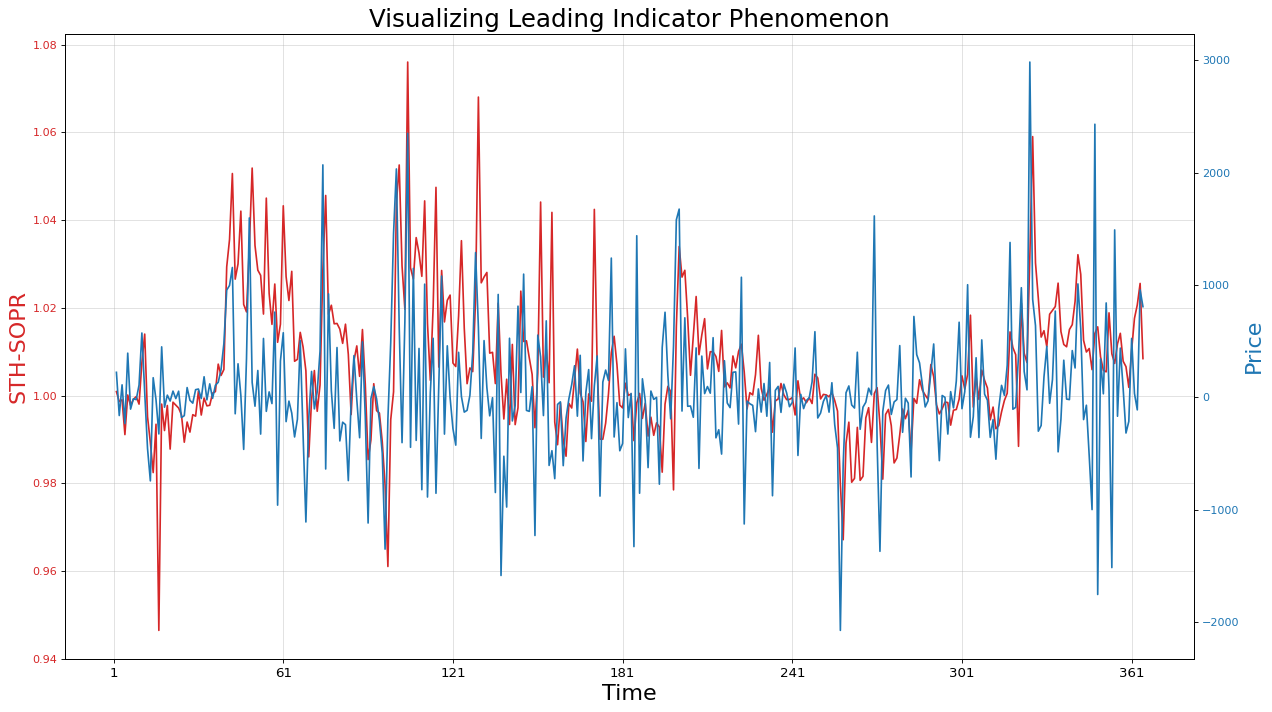

In [4]:
# Plot Line1 (Left Y Axis)
fig, ax1 = plt.subplots(1,1,figsize=(16,9), dpi= 80)
ax1.plot(x, y1, color='tab:red')

# Plot Line2 (Right Y Axis)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(x, y2_diff, color='tab:blue')

# Decorations
# ax1 (left Y axis)
ax1.set_xlabel('Time', fontsize=20)
ax1.tick_params(axis='x', rotation=0, labelsize=12)
ax1.set_ylabel('STH-SOPR', color='tab:red', fontsize=20)
ax1.tick_params(axis='y', rotation=0, labelcolor='tab:red' )
ax1.grid(alpha=.4)

# ax2 (right Y axis)
ax2.set_ylabel("Price", color='tab:blue', fontsize=20)
ax2.tick_params(axis='y', labelcolor='tab:blue')
ax2.set_xticks(np.arange(0, len(x), 60))
ax2.set_xticklabels(x[::60], rotation=90, fontdict={'fontsize':10})
ax2.set_title("Visualizing Leading Indicator Phenomenon", fontsize=22)
fig.tight_layout()
plt.show()


In [5]:
#combine the data from two DataFrames
data_matrix = y2_diff.join(y1)
data_matrix.columns = ['price_change', 'SHT-SOPR']
print(data_matrix.head())

   price_change  SHT-SOPR
1    221.887056  1.000897
2   -162.887571  0.998625
3    110.566398  0.999037
4   -234.503472  0.991092
5    392.744986  1.000127


In [16]:
# The Granger Causality Test Function in Python Statsmodels using the article https://www.machinelearningplus.com/time-series/granger-causality-test-in-python/

maxlag = 7
test   = 'ssr_chi2test'

def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

In [17]:
grangers_causation_matrix(data_matrix, variables = data_matrix.columns)  

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


,price_change_x,SHT-SOPR_x
price_change_y,1.0,0.1455
SHT-SOPR_y,0.0,1.0000
